In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

In [22]:
from scipy.stats import norm

sigma = 10
cost = 1
# high value of planning: sigma=30, c=0.01
# medium value of planning: sigma=28, c=1.00
# low value of planning: sigma=1, c=4.00

def make_env(sigma=sigma, cost=cost, n=4):
    d = norm(0, sigma)
    vals = np.linspace(-1.5*sigma, 1.5*sigma, n)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    reward = Categorical(vals, probs)
    # vals = [-5, -1, 1, 5]
    # probs = [.1, .4, .4, .1]
    # reward = Categorical(vals, probs)
    return MouselabEnv([4,1,2], reward=reward, cost=cost,
                       ground_truth=[0, *reward.sample(16)])

def make_envs(seed=0, n=16):
    np.random.seed(seed)
    return [make_env() for _ in range(n)]

envs = make_envs(3)
TERM = envs[0].term_action

In [23]:
import json
def save_envs(envs):
    data = [{'stateRewards': e.ground_truth.tolist()} for e in envs]
    with open('../experiments/exp1/static/json/med_cost.json', 'w+') as f:
        json.dump(data, f)
        
save_envs(envs)

In [26]:
from policies import MouselabPolicy
from skopt import gp_minimize
bounds = [ (-30., 30.) ] * 4
agent = Agent()

def evaluate(policy, envs):
    def run_env(policy, env):
        agent.register(policy)
        agent.register(env)
        tr = agent.run_episode()
        return {'util': tr['return'],
                'observations': len(tr['actions']) - 1}
    return pd.DataFrame(run_env(policy, env) for env in envs)

def optimize(envs):    
    def objective(theta):
        theta = np.array(theta)
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        print(theta.round(3), util)
        return - util
    
    return gp_minimize(objective, bounds, n_calls=50, random_state=123)

In [25]:
agent = Agent()
result = optimize(envs)
print(np.array(result.x).round(3))

[ 11.788 -12.832 -16.389   3.079] -0.625
[ 13.168  -4.614  28.846  11.09 ] 12.0625
[ -1.144  -6.473  -9.409  13.743] 3.25
[ -3.686 -26.419  -6.117  14.28 ] 1.875
[-19.05  -19.473   1.893   1.91 ] -0.625
[  8.064  20.966  13.467   6.661] 11.5
[ 13.347 -10.622  -8.293 -16.304] -0.625
[-12.377   7.859 -24.474  -3.978] -0.625
[ -4.148  -0.379  -4.45  -11.264] -0.625
[ -4.419  23.603  26.65    0.11 ] 11.125
[ 13.415  -4.208  28.932  11.744] 12.1875
[ 14.822  -0.907  29.557  14.551] 12.1875
[ 13.783  23.868  20.056   9.85 ] 11.5625
[ 30.    -25.242  30.     26.363] 10.5625
[ 14.319  -2.082  29.385  13.563] 12.1875
[ 14.162  -2.287  29.314  13.767] 12.1875
[ 14.634  -2.516  29.412  13.687] 12.1875
[ 12.995  -1.899  29.114  13.841] 12.0
[ 17.869  -2.976  29.998  13.059] 12.1875
[ 16.94   -0.804  30.     11.669] 12.4375
[ 19.343   1.98   30.      9.231] 11.25
[ 15.455   0.616  30.     11.937] 11.25
[ 19.035  -7.942  30.     16.203] 11.8125
[ -5.744  -2.436  29.216  16.942] 11.25
[ 20.618   0.12

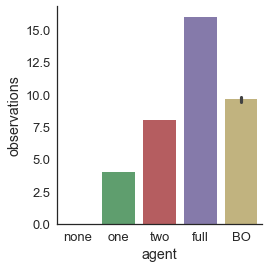

In [17]:
def data():
    policies = {
        'BO': MouselabPolicy(np.array([*result.x])),
        'full': FixedPlanPolicy(range(1, TERM+1)),
        'none': FixedPlanPolicy([TERM]),
        'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
        'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
    }
    def dfs():
        for name, policy in policies.items():
            df = evaluate(policy, envs=make_envs(3))
            df['agent'] = name
            # print('======= {} ======='.format(name))
            # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
            # print('Return: {:.3f}'.format(df.util.mean() / sigma))
            yield df
    return pd.concat(dfs())
    
df = data()
big_df = pd.concat([df] * 50)
sns.factorplot('agent', 'util', data=big_df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

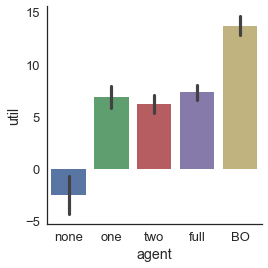

In [27]:
sns.factorplot('agent', 'util', data=big_df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

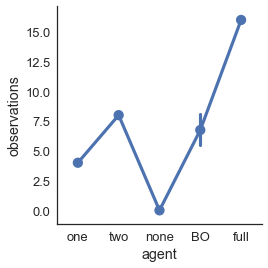

In [12]:
sns.factorplot('agent', 'observations', data=df)

In [47]:
util = df.groupby('agent').util
sem = util.std() / np.sqrt(50)
util.mean() / sem

agent
BO      5.333844
full    2.722179
none   -2.886751
one     1.233905
two     1.825742
Name: util, dtype: float64

In [12]:
def data():
    agent.register(env)
    policies = {
#         'BO': MouselabPolicy(np.array([*result.x])),
        'full': FixedPlanPolicy(range(1, TERM+1)),
        'none': FixedPlanPolicy([TERM]),
        'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
        'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
    }
    def dfs():
        for name, policy in policies.items():
            print(name)
            agent.register(policy)
            # df = pd.DataFrame(agent.run_many(100, pbar=0))
            
            df['agent'] = name
            print('======= {} ======='.format(name))
            print('Observations: {:.3f}'.format(df.n_steps.mean() - 2))
            print('Return: {:.3f}'.format(df['return'].mean() / sigma))
            yield df
    return pd.concat(dfs())
    
df = data()

NameError: name 'env' is not defined